# Natural Policy Gradient (NPG)

---

今回はNPGの解説を行います．


まず，以下の最適化問題について考えます．

$$
V^\pi(\rho):=\mathbb{E}_{x_0 \sim \rho}\left[V^\pi\left(s_0\right)\right],
$$

$$
\max _{\theta \in \Theta} V^{\pi_\theta}(\rho) \text {. }
$$

ここで$\rho$は初期状態分布です．




つまり，上の最適化問題の式がconcaveなら，微分して最大化できるパラメータを求めれば良いとなりますね．

なので，まずは価値関数の微分を考えていきます．



まず，履歴$\tau$を考えます．

その履歴に沿った，方策と確率遷移の同時確率の記法を以下に示します．

$$
\operatorname{Pr}_\mu^\pi(\tau)=\mu\left(s_0\right) \pi\left(a_0 \mid s_0\right) P\left(s_1 \mid s_0, a_0\right) \pi\left(a_1 \mid s_1\right) \cdots
$$

割引総報酬和を次のように定義します．

$$
R(\tau):=\sum_{t=0}^{\infty} \gamma^t r\left(s_t, a_t\right)
$$

$$
V^{\pi \theta}(\mu)=\mathbb{E}_{\tau \sim \operatorname{Pr}_\mu^{\pi_\theta}}^{\pi_\theta}[R(\tau)] .
$$

しかしながら，方策で決定的な場合，微分不可になってしまうので，次のように変換して考えます．

$$
\pi_\theta(a \mid s)=\frac{\exp \left(\theta_{s, a}\right)}{\sum_{a^{\prime}} \exp \left(\theta_{s, a^{\prime}}\right)},
$$

---

ここでなぜNPGを使わなきゃいけないかというと，価値関数がConvex関数にならないようなMDPが存在するためです．

NPGはその凸性を確認しなくてもいいので，便利ですね．

しかしながら，上の価値関数の定義からわかるように，モンテカルロのような推定をしていますね．

その理由は．勾配を計算するのが難しくなってしまうからです．(勾配方向がわからなくなってしまうため)


---

次のようなMDPを考えます．

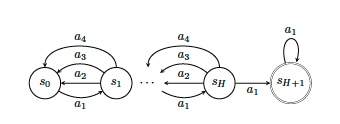

報酬は$s_{H+1}$ に到達した時だけ，発生するとします．

この場合，各状態にパラメータを持つとすると最大で，$4^{|S|}$個もち，報酬が発生する確率が稀なため，十分な探索が必要になりかつ，勾配が小さいので，勾配消失の問題になりますね．

単のPolicy Gradientの場合，勾配が不安定だと，更新が不安定になります．

---

上のMDPでは探索が重要ですが，上で示した，ソフトマックスで方策を変換すると，決定的な方策に近づくように急激に更新してしまうため，学習の面ではあまり良くないですね．

そこでNPGが考えられる前では，正則化項を入れるという考えになりました．

正則化項を入れた新しい目的関数は次のようになります．

$$
\begin{aligned}
L_\lambda(\theta) & :=V^{\pi_\theta}(\mu)-\lambda \mathbb{E}_{\boldsymbol{s} \sim \mathrm{Unif}_S}\left[\mathrm{KL}\left(\text { Unif }_{\mathcal{A}}, \pi_\theta(\cdot \mid s)\right)\right] \\
& =V^{\pi_\theta}(\mu)+\frac{\lambda}{|\mathcal{S}||\mathcal{A}|} \sum_{\dot{s}, a} \log \pi_\theta(a \mid s)+\lambda \log |\mathcal{A}|,
\end{aligned}
$$

このようにすると，パラメータの更新は次のようになります．

$$
\theta^{(t+1)}=\theta^{(t)}+\eta \nabla_\theta L_\lambda\left(\theta^{(t)}\right) .
$$

---

KL-距離関数で正則化するというアイデアを活かし，更新の安定性や，収束の速さのどを考慮した方法がNPGになります．

以降に出てくるフィッシャー行列はKL-距離関数のテーラー展開の2次近似になります，


フィッシャー行列の定義は次のようになります．

$$
\mathcal{F}_\rho^\theta:=\mathbb{E}_{g \sim d_\rho^{\pi_\theta}} \mathbb{E}_{a \sim \pi_\theta(\cdot \mid s)}\left[\left(\nabla \log \pi_\theta(a \mid s)\right) \nabla \log \pi_\theta(a \mid s)^{\top}\right]
$$

パラメータの更新則は次のようになります，

$$
\theta^{(t+1)}=\theta^{(t)}+\eta F_\rho\left(\theta^{(t)}\right)^{\dagger} \nabla_\theta V^{(t)}(\rho)
$$

フィッシャー情報量の定義は
$$
\mathcal{F}_\rho^\theta:=\mathbb{E}_{s \sim d_\rho^{\pi_\theta}} \mathbb{E}_{a \sim \pi_\theta(\cdot \mid s)}\left[\left(\nabla \log \pi_\theta(a \mid s)\right) \nabla \log \pi_\theta(a \mid s)^{\top}\right]
$$

上記のフィッシャー情報行列はMoore-Penrose擬似逆を使っています．

これを使うことによって状態分布の影響を打ち消し，逆行列の計算が楽になります．

逆行列の存在性の有無が確認しなくても良くなります．



パラメータの更新方法は次のように書き換えられて，方策は次のように変換されます．

$$
\theta^{(t+1)}=\theta^{(t)}+\frac{\eta}{1-\gamma} A^{(t)}+\eta v \quad \text { かつ } \quad \pi^{(t+1)}(a \mid s)=\pi^{(t)}(a \mid s) \frac{\exp \left(\eta A^{(t)}(s, a) /(1-\gamma)\right)}{Z_t(s)}
$$

---

**最適な価値関数の計算**

In [2]:
# MDPの構築

import numpy as np
import jax
import jax.numpy as jnp
from typing import NamedTuple,Optional
np.random.seed(10)

S = 5 # 状態数
A = 3 # 行動数
S_set = np.arange(S)
A_set = np.arange(A)
gamma = 0.9 # 割引率

rew = np.random.randn(S,A) # 報酬
rew = np.array(rew)

P = np.random.rand(S,A,S) # 遷移確率
P = P.reshape(S*A,S)
P = P/np.sum(P,axis=1,keepdims=True) # 正規化
P = P.reshape(S,A,S)
np.testing.assert_allclose(P.sum(axis=-1), 1, atol=1e-6)

class MDP(NamedTuple):
    S_set: np.ndarray
    A_set: np.ndarray
    rew: np.ndarray
    P: np.ndarray
    gamma: float
    H: int
    optimal_V: Optional[np.ndarray] = None

    @property
    def S(self):
        return len(self.S_set)

    @property
    def A(self):
        return len(self.A_set)

H = int (1/(1-gamma) + 100)
mdp = MDP(S_set,A_set,rew,P,gamma,H)

In [3]:
from functools import partial

@partial(jax.jit,static_argnames=('S','A'))
def _optimal_Q(S:int,A:int,mdp:MDP):
    Q = jnp.zeros((S,A))

    def backup(Q):
        V = jnp.max(Q,axis=1)
        return mdp.rew + mdp.gamma * jnp.dot(mdp.P,V)
    
    body_fn = lambda i,Q: backup(Q)
    return jax.lax.fori_loop(0,mdp.H,body_fn,Q)

compute_optimal_Q = lambda mdp : _optimal_Q(mdp.S,mdp.A,mdp)
optimal_Q = compute_optimal_Q(mdp)
optimal_V = np.max(optimal_Q,axis=1)
mdp = mdp._replace(optimal_V=optimal_V)

In [4]:
@partial(jax.jit,static_argnames=('S','A'))
def _comupute_policy_Q(S:int,A:int,mdp:MDP,policy:np.ndarray):
    Q = jnp.zeros((S,A))
    def backup(Q):
        max_Q = (policy * Q).sum(axis=1)
        next_v = mdp.P @ max_Q
        return mdp.rew + mdp.gamma * next_v
    body_fn = lambda i,Q:backup(Q)
    return jax.lax.fori_loop(0,mdp.H,body_fn,Q)
compute_policy_Q = lambda mdp,policy:_comupute_policy_Q(mdp.S,mdp.A,mdp,policy)


In [19]:
from jax import grad
from tqdm import tqdm
def softmax(x):
    e_x = jnp.exp(x - jnp.max(x))
    return e_x / jnp.sum(e_x)

def compute_policy(policy,advantage,learning_rate):
    return policy * softmax(learning_rate * advantage/(1- mdp.gamma))


def kl_divergence(p,q):
    return jnp.sum(p * jnp.log(p/q))

def natural_grad(advantage,learning_rate):


    return  learning_rate * advantage / (1-mdp.gamma) + learning_rate * 0.1


def natural_policy_gradient(learning_rate, num_iterations):
    key = jax.random.PRNGKey(0)
    params = jax.random.normal(key, (mdp.S, mdp.A))
    Q = np.zeros((mdp.S,mdp.A))
    policy = np.zeros_like(Q)
    advantage = np.zeros_like(Q)

    for _ in tqdm(range(num_iterations)):

        policy = compute_policy(policy, advantage, learning_rate) 
        max_Q = (policy * Q).sum(axis=1)
        next_v = mdp.P @ max_Q
        Q = mdp.rew + mdp.gamma * next_v

        advantage = Q - Q.max(axis=1,keepdims=True)


        natural_grads = natural_grad(advantage,learning_rate)
        params += natural_grads

        

    return Q

learning_rate = 0.8
num_iterations = 100000

Q = natural_policy_gradient(learning_rate, num_iterations)

print(optimal_Q - Q)

100%|██████████| 100000/100000 [00:20<00:00, 4808.15it/s]

[[7.9401793 7.8497214 7.780638 ]
 [7.6949606 7.931794  7.789324 ]
 [7.7100496 7.9122024 7.825548 ]
 [7.9252543 7.8050566 7.724204 ]
 [7.8208895 7.846544  8.025346 ]]


In [17]:
optimal_Q


Array([[9.271766 , 8.565001 , 6.235238 ],
       [7.686577 , 8.55313  , 7.069238 ],
       [7.975561 , 8.020751 , 7.8298397],
       [7.750654 , 8.238083 , 8.927241 ],
       [6.855824 , 8.874818 , 8.253976 ]], dtype=float32)

In [18]:
Q

Array([[ 1.3315865 ,  0.715279  , -1.5454003 ],
       [-0.00838385,  0.621336  , -0.72008556],
       [ 0.26551157,  0.10854852,  0.00429143],
       [-0.17460021,  0.4330262 ,  1.2030374 ],
       [-0.96506566,  1.028274  ,  0.22863013]], dtype=float32)